In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd "drive/My Drive/Internship"

/content/drive/My Drive/Internship


In [ ]:
ls

 MSFT1.csv   msft.us.txt           'Sentiment Analysis.ipynb'  'TCS SA.ipynb'
 MSFT.csv    NSE-TATAGLOBAL11.csv   TCS.NS.csv


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.6MB/s 
     |████████████████████████████████| 8.7MB 8.0MB/s 
     |████████████████████████████████| 2.1MB 47.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('MSFT.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-09,136.000000,136.970001,135.800003,136.460007,134.801239,19953100
2019-07-10,137.130005,138.580002,137.020004,137.850006,136.174347,24204400
2019-07-11,138.199997,139.220001,137.869995,138.399994,136.717636,22327900
2019-07-12,138.850006,139.130005,138.009995,138.899994,137.211563,18936800
2019-07-15,139.440002,139.539993,138.460007,138.899994,137.211563,16651500
...,...,...,...,...,...,...
2020-07-01,203.139999,206.350006,201.770004,204.699997,204.699997,32061200
2020-07-02,205.679993,208.020004,205.000000,206.259995,206.259995,29315800
2020-07-06,208.830002,211.130005,208.089996,210.699997,210.699997,31897600


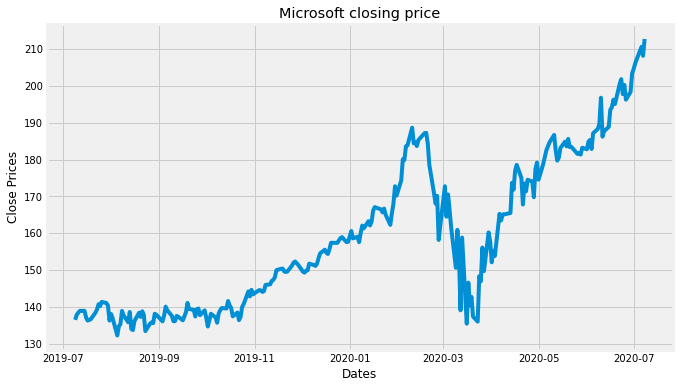

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Microsoft closing price')
plt.show()


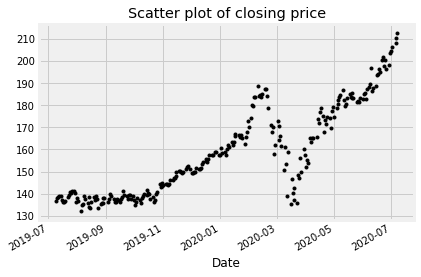

In [ ]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()


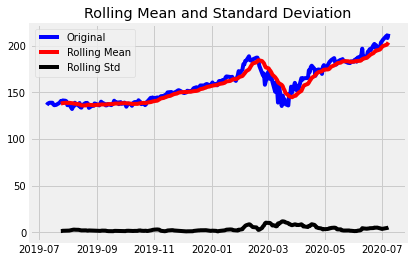

Results of dickey fuller test
Test Statistics                 -0.127876
p-value                          0.946590
No. of lags used                 9.000000
Number of observations used    243.000000
critical value (1%)             -3.457551
critical value (5%)             -2.873509
critical value (10%)            -2.573148
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)


<Figure size 432x288 with 0 Axes>

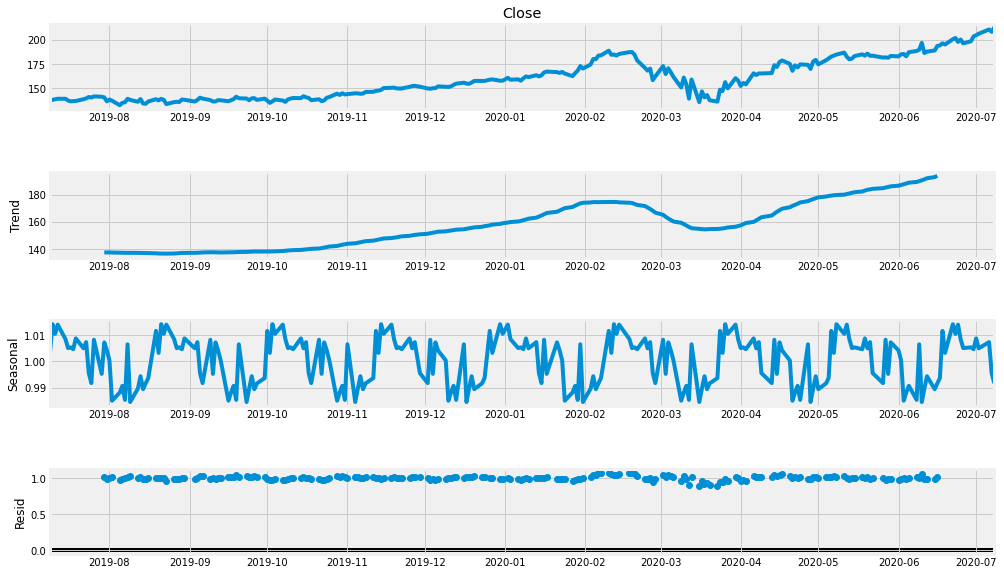

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


No handles with labels found to put in legend.


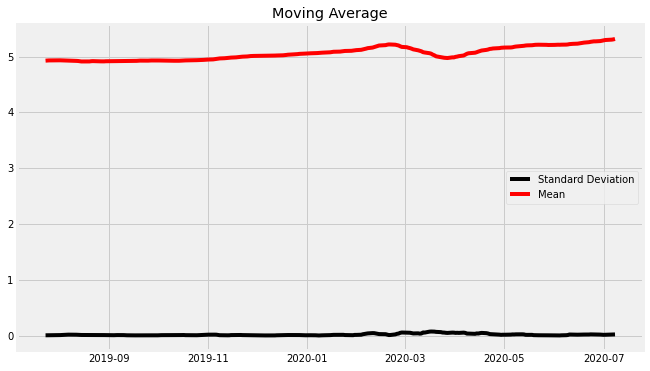

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


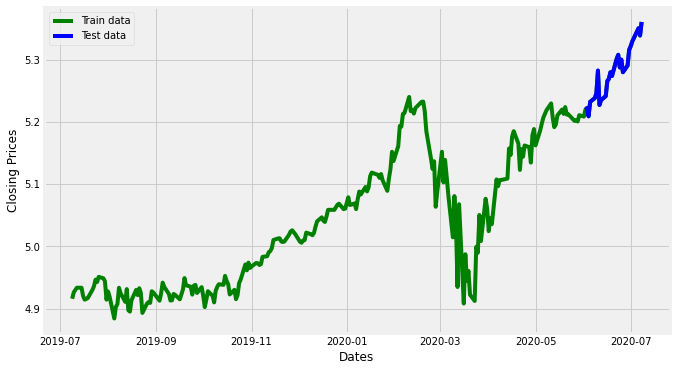

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-985.863, BIC=-979.049, Time=0.085 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-1039.132, BIC=-1028.910, Time=0.067 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-1027.948, BIC=-1017.727, Time=0.195 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-987.374, BIC=-983.967, Time=0.018 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-1037.392, BIC=-1023.763, Time=0.142 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-1037.283, BIC=-1023.654, Time=0.201 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-1035.138, BIC=-1018.102, Time=0.281 seconds
Total fit time: 1.009 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  224
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 522.566
Date:                Thu, 30 Jul 20

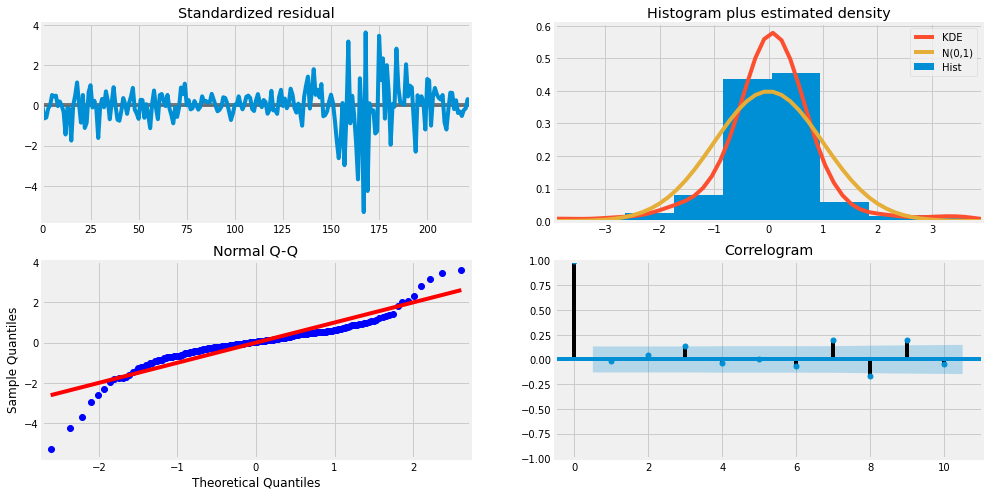

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 522.566
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 30 Jul 2020   AIC                          -1039.133
Time:                        15:15:56   BIC                          -1028.911
Sample:                             1   HQIC                         -1035.007
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.168      0.243      -0.001       0.003
ar.L1.D.Close    -0.4674      0.059     -7.932      0.000      -0.583      -0.352
                                    Root

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


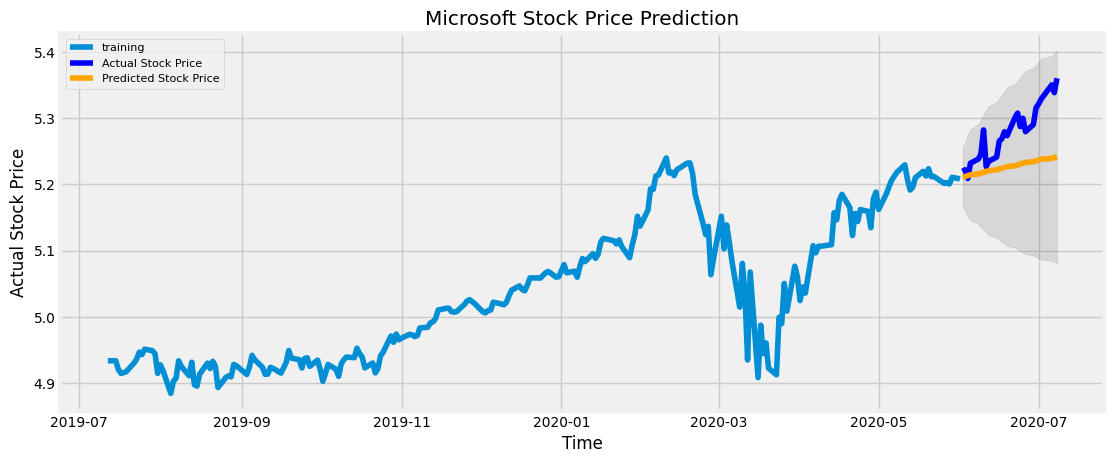

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(26, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 0.0037650184164837587
MAE: 0.051798501455889524
RMSE: 0.06135974589650579
MAPE: 0.009765677316498654
